In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd gdrive/MyDrive/ai-ut/NNDL

/content/gdrive/.shortcut-targets-by-id/1n51YjQLvH7GoayebFkx66qsnFAEUwF6Y/ai-ut/NNDL


In [ ]:
%cd gdrive/MyDrive/NNDL

/content/gdrive/MyDrive/NNDL


In [ ]:
!unrar x "/content/gdrive/MyDrive/Untitled Folder/NN_HW2_Face_Emotion.rar" "/content/AffectNet/"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal

Cannot open /content/gdrive/MyDrive/Untitled Folder/NN_HW2_Face_Emotion.rar
No such file or directory
No files to extract


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the paths to the training and tuning data
train_dir = 'AffectNet/TRAIN'
tune_dir = 'AffectNet/TUNE'

# Define the dataset parameters
batch_size = 32
img_height = 128
img_width = 128

# Create a data augmentation layer to be included inside your model
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.Rescaling(1./255) # Rescaling layer to normalize the pixel values
  ]
)

# Load the training dataset and include the data augmentation and rescaling layers
train_dataset = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Load the validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Load the tuning dataset (without augmentation for evaluation purposes)
tune_dataset = tf.keras.utils.image_dataset_from_directory(
  tune_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# # Apply the data augmentation to the training dataset
# augmented_train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# # Remember to prefetch the datasets for performance optimization
# AUTOTUNE = tf.data.AUTOTUNE
# train_dataset = augmented_train_dataset.prefetch(buffer_size=AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# tune_dataset = tune_dataset.prefetch(buffer_size=AUTOTUNE)


Found 8010 files belonging to 8 classes.
Using 6408 files for training.
Found 8010 files belonging to 8 classes.
Using 1602 files for validation.
Found 1600 files belonging to 8 classes.


In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout,GaussianDropout, DepthwiseConv2D, GlobalAveragePooling2D
from keras.optimizers import Adam

def depth_conv_block(model, d, k, s):
    model.add(DepthwiseConv2D((k, k), strides=(s, s), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(d, (1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    return model

def MobileNet():
    model = Sequential()
    alpha = 1
    # CONV
    model.add(Conv2D(int(32 * alpha), (3, 3), padding='same', use_bias=False, strides=(2, 2), input_shape=(128, 128, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # DEPTHWISE CONVS
    model = depth_conv_block(model, int(64 * alpha), 3, 1)

    model = depth_conv_block(model, int(128 * alpha), 3, 2)
    model = depth_conv_block(model, int(128 * alpha), 3, 1)

    model = depth_conv_block(model, int(256 * alpha), 3, 2)
    model = depth_conv_block(model, int(256 * alpha), 3, 1)

    model = depth_conv_block(model, int(512 * alpha), 3, 2)
    model = depth_conv_block(model, int(512 * alpha), 3, 1)
    model = depth_conv_block(model, int(512 * alpha), 3, 1)
    model = depth_conv_block(model, int(512 * alpha), 3, 1)
    model = depth_conv_block(model, int(512 * alpha), 3, 1)
    model = depth_conv_block(model, int(512 * alpha), 3, 1)

    model = depth_conv_block(model, int(1024 * alpha), 3, 2)
    model = depth_conv_block(model, int(1024 * alpha), 3, 1)
    # FLATTEN
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.3))
    # OUTPUT
    model.add(Dense(8, activation='softmax'))
    # model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.005, clipnorm=1.0), metrics=['accuracy'])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Summary of the model
    model.summary()

    return model

In [ ]:
model = MobileNet()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 64, 64, 32)        864       
                                                                 
 batch_normalization_162 (B  (None, 64, 64, 32)        128       
 atchNormalization)                                              
                                                                 
 activation_162 (Activation  (None, 64, 64, 32)        0         
 )                                                               
                                                                 
 depthwise_conv2d_78 (Depth  (None, 64, 64, 32)        288       
 wiseConv2D)                                                     
                                                                 
 batch_normalization_163 (B  (None, 64, 64, 32)        128       
 atchNormalization)                                   

In [ ]:
from tensorflow.keras.optimizers import Adam

# Assuming 'model' is your pre-defined Keras model

# Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
initial_epochs = 10  # for example, set the number of epochs for initial training
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    batch_size=32,
    validation_data=validation_dataset
)

# Now, let's fine-tune the model
# For fine-tuning, you might want to modify the learning rate, unfreeze some layers etc.
# This part depends on your specific model and approach
model.compile(optimizer=Adam(learning_rate=0.0001),  # Reduced learning rate for fine-tuning
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 5  # Set the number of fine-tuning epochs
total_epochs = initial_epochs + fine_tune_epochs

# Fine-tune the model
fine_tune_history = model.fit(
    tune_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset
)

# Save the model if necessary
model.save('path_to_my_model.h5')


Epoch 1/10
201/201 [==============================] - 29s 82ms/step - loss: 2.1362 - accuracy: 0.1667 - val_loss: 2.3130 - val_accuracy: 0.1223
Epoch 2/10
201/201 [==============================] - 16s 79ms/step - loss: 1.7476 - accuracy: 0.2718 - val_loss: 2.3014 - val_accuracy: 0.1223
Epoch 3/10
201/201 [==============================] - 16s 78ms/step - loss: 1.6535 - accuracy: 0.3099 - val_loss: 2.0554 - val_accuracy: 0.2135
Epoch 4/10
201/201 [==============================] - 16s 77ms/step - loss: 1.5813 - accuracy: 0.3514 - val_loss: 1.5326 - val_accuracy: 0.3783
Epoch 5/10
201/201 [==============================] - 15s 73ms/step - loss: 1.4993 - accuracy: 0.3853 - val_loss: 1.6856 - val_accuracy: 0.3489
Epoch 6/10
201/201 [==============================] - 18s 85ms/step - loss: 1.3924 - accuracy: 0.4380 - val_loss: 1.6338 - val_accuracy: 0.3677
Epoch 7/10
201/201 [==============================] - 16s 77ms/step - loss: 1.3311 - accuracy: 0.4663 - val_loss: 1.7200 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

additional_epochs = 10
# Continue training the model
continued_history = model.fit(
    train_generator,
    epochs=additional_epochs+initial_epochs,
    initial_epoch=history.epoch[-1] + 1,
    validation_data=validation_generator
)

model.compile(optimizer=Adam(learning_rate=0.0001),  # Reduced learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

additional_fine_tune_epochs = 5
# Fine-tune the model again
additional_fine_tune_history = model.fit(
    tune_generator,
    epochs=additional_fine_tune_epochs+total_epochs,
    initial_epoch=fine_tune_history.epoch[-1] + 1,
    validation_data=validation_generator
)

# Combine the history from the previous training session with the new one
# Note that 'history.history' is a dictionary with keys for each metric
# For each metric, extend the list with the values from the continued training
for key in history.history:
    history.history[key].extend(continued_history.history[key])

for key in fine_tune_history.history:
    fine_tune_history.history[key].extend(additional_fine_tune_history.history[key])

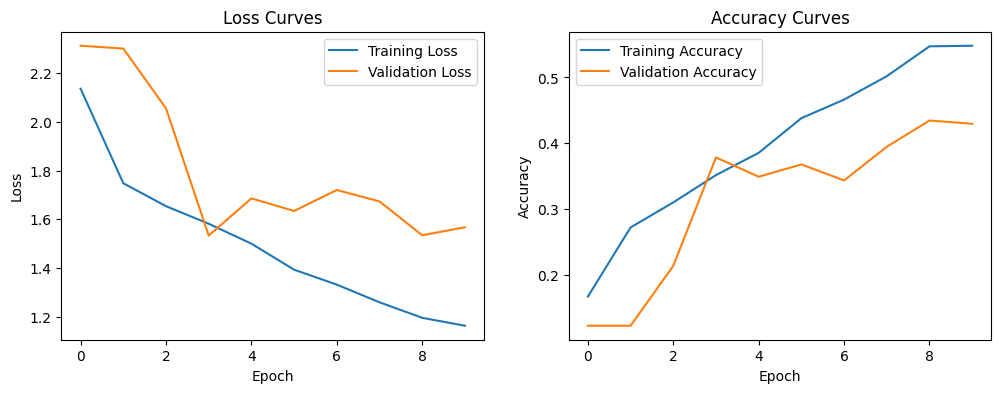

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import label_binarize
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# Plotting Loss and Accuracy curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()